1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


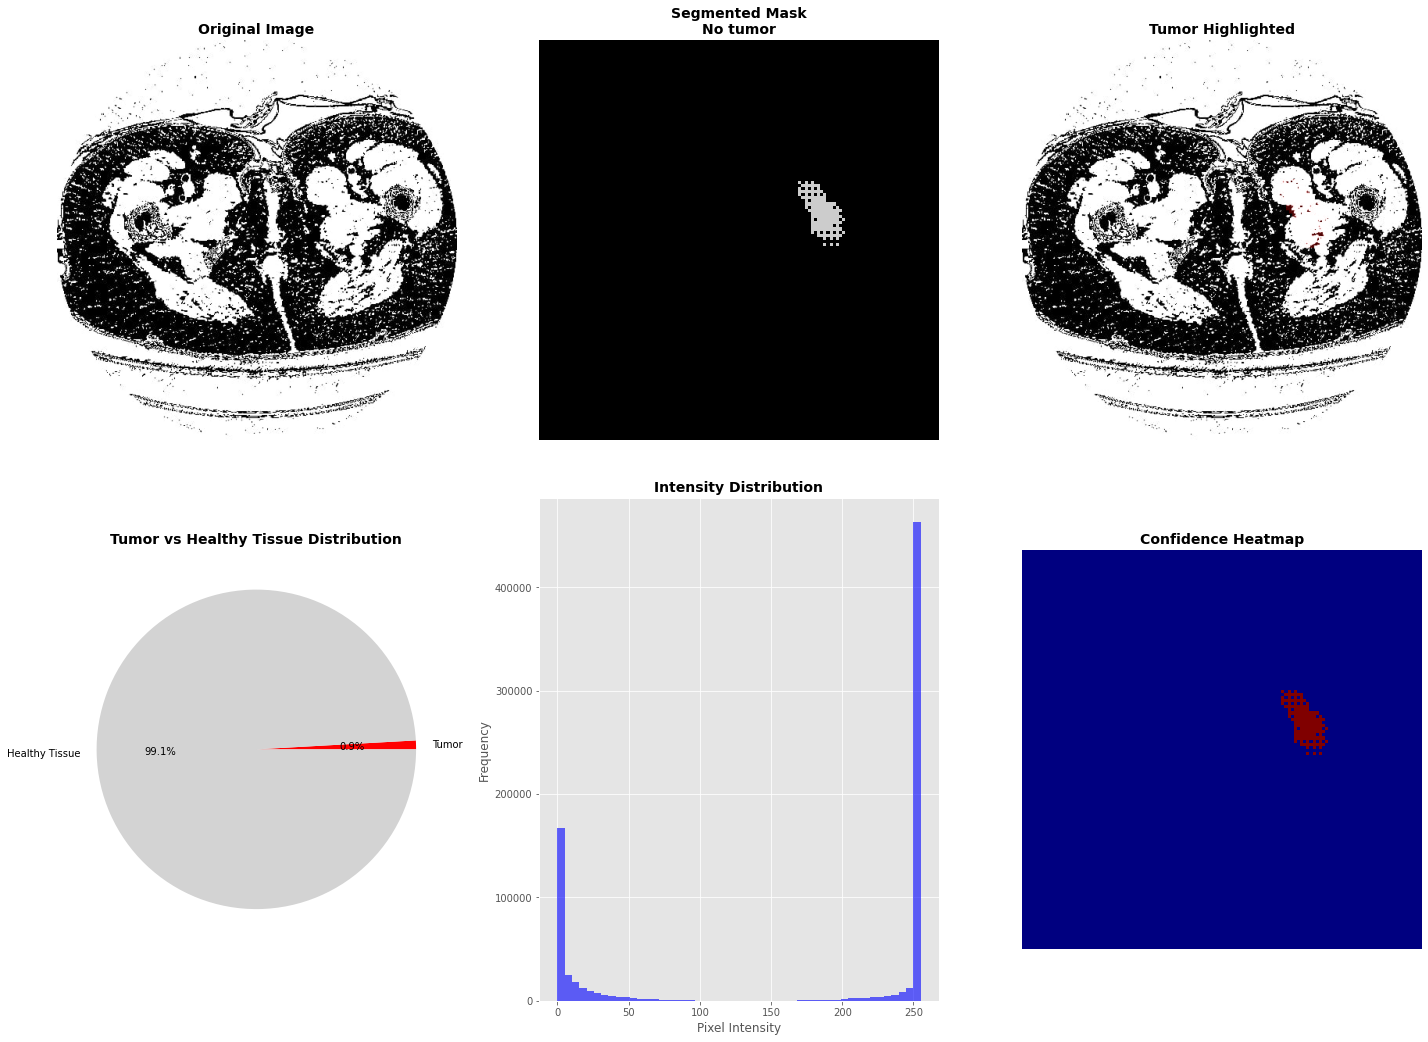

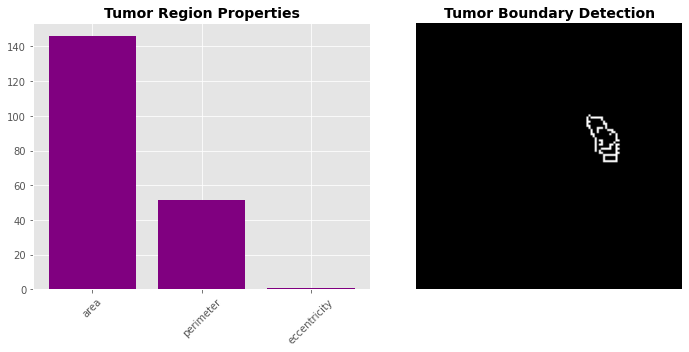


Detailed Analysis:
Tumor Classification: No tumor
Tumor Size: 0.89% of total area
Tumor Perimeter: 51.56 pixels
Tumor Eccentricity: 0.89


In [1]:
# Step 1: Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as keras
from sklearn.metrics import confusion_matrix
import pandas as pd
from skimage.measure import regionprops

# Step 2: Define Dice Coefficient and Loss functions
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Step 3: Define the CNN model
def getCNNModel(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, (3, 3), dilation_rate=2, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate=2)(conv1)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), dilation_rate=2, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', dilation_rate=2)(conv2)
    conv2 = Dropout(0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), dilation_rate=2, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=2)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), dilation_rate=2, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), dilation_rate=2, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

def predict(image_path, model):
    # Read and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    # Make prediction
    pred = model.predict(img)
    pred = (pred > 0.5).astype(np.uint8)
    
    # Save the segmented mask
    cv2.imwrite("segmented_mask.png", pred[0, :, :, 0] * 255)
    
    return pred[0, :, :, 0]

def classify_tumor_stage(segmented_mask):
    white_pixel_percentage = np.mean(segmented_mask) * 100
    if white_pixel_percentage < 1:
        return 'No tumor'
    elif white_pixel_percentage < 1.5:
        return 'Stage I'
    elif white_pixel_percentage < 5:
        return 'Stage II'
    elif white_pixel_percentage < 10:
        return 'Stage III'
    else:
        return 'Stage IV'

def highlight_tumor(original_image, mask):
    # Resize mask to match original image size if necessary
    mask = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]))
    
    # Create a copy of the original image
    highlighted_image = original_image.copy()
    
    # Create a red overlay for the tumor region
    red_overlay = np.zeros_like(original_image)
    red_overlay[mask > 0] = [0, 0, 255]  # Red color in BGR
    
    # Blend the original image with the red overlay
    alpha = 0.3  # Transparency factor
    highlighted_image = cv2.addWeighted(highlighted_image, 1, red_overlay, alpha, 0)
    
    return highlighted_image

# Step 5: Load model and run analysis
cnn_model = getCNNModel(input_size=(128, 128, 1))
cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])
cnn_model.load_weights("cnn_weights.hdf5")

# Run predictions
image_path = "1.jpeg"
img_original = cv2.imread(image_path)
segmented_mask = predict(image_path, cnn_model)
tumor_stage = classify_tumor_stage(segmented_mask)
img_mask = cv2.imread("segmented_mask.png", cv2.IMREAD_GRAYSCALE)
highlighted_image = highlight_tumor(img_original, img_mask)

# Set style for all plots
plt.style.use('ggplot')  # Using 'ggplot' style instead of 'seaborn'
    
# 1. Main Results Visualization
fig = plt.figure(figsize=(20, 15))
    
# Original Image
plt.subplot(2, 3, 1)
plt.title("Original Image", fontsize=14, fontweight='bold')
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.axis('off')
    
# Segmented Mask
plt.subplot(2, 3, 2)
plt.title(f"Segmented Mask\n{tumor_stage}", fontsize=14, fontweight='bold')
plt.imshow(img_mask, cmap='nipy_spectral')
plt.axis('off')
    
# Highlighted Tumor
plt.subplot(2, 3, 3)
plt.title("Tumor Highlighted", fontsize=14, fontweight='bold')
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
    
# 2. Tumor Size Analysis
plt.subplot(2, 3, 4)
tumor_size = np.sum(segmented_mask) / (segmented_mask.shape[0] * segmented_mask.shape[1])
sizes = ['Tumor', 'Healthy Tissue']
values = [tumor_size, 1 - tumor_size]
plt.pie(values, labels=sizes, autopct='%1.1f%%', colors=['red', 'lightgray'])
plt.title("Tumor vs Healthy Tissue Distribution", fontsize=14, fontweight='bold')
    
# 3. Intensity Distribution
plt.subplot(2, 3, 5)
plt.hist(img_original.ravel(), bins=50, color='blue', alpha=0.6)
plt.title("Intensity Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
    
# 4. Confidence Heatmap
plt.subplot(2, 3, 6)
confidence_map = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
plt.imshow(cv2.cvtColor(confidence_map, cv2.COLOR_BGR2RGB))
plt.title("Confidence Heatmap", fontsize=14, fontweight='bold')
plt.axis('off')
    
plt.tight_layout()
plt.show()
    
# Additional Analysis Plots
fig = plt.figure(figsize=(15, 5))
    
# 6. Region Properties
plt.subplot(1, 3, 1)
props = regionprops(img_mask.astype(int))
if len(props) > 0:
    metrics = ['area', 'perimeter', 'eccentricity']
    values = [props[0].area, props[0].perimeter, props[0].eccentricity]
    plt.bar(metrics, values, color='purple')
    plt.title("Tumor Region Properties", fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    
# 7. Edge Detection
plt.subplot(1, 3, 2)
edges = cv2.Canny(img_mask, 100, 200)
plt.imshow(edges, cmap='gray')
plt.title("Tumor Boundary Detection", fontsize=14, fontweight='bold')
plt.axis('off')
    
plt.tight_layout()
plt.show()
    
# Print detailed analysis
print("\nDetailed Analysis:")
print(f"Tumor Classification: {tumor_stage}")
print(f"Tumor Size: {tumor_size * 100:.2f}% of total area")
if len(props) > 0:
    print(f"Tumor Perimeter: {props[0].perimeter:.2f} pixels")
    print(f"Tumor Eccentricity: {props[0].eccentricity:.2f}")


# 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


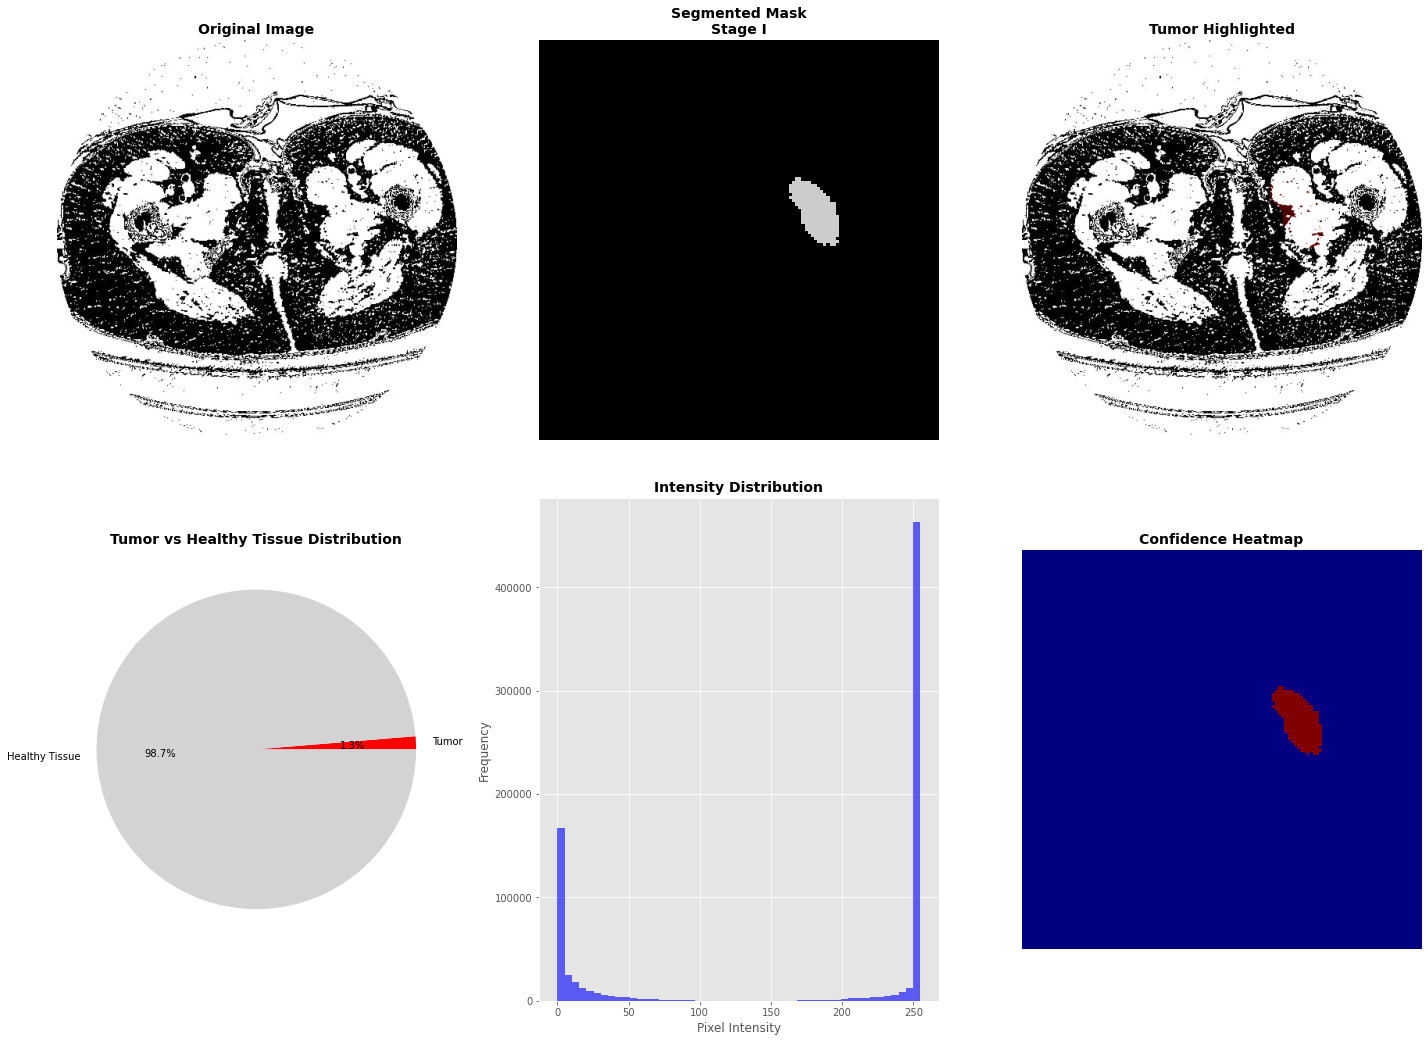

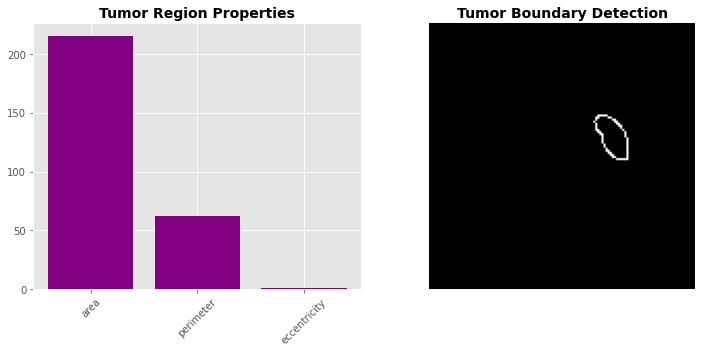


Detailed Analysis:
Tumor Classification: Stage I
Tumor Size: 1.31% of total area
Tumor Perimeter: 62.18 pixels
Tumor Eccentricity: 0.89


In [2]:
# Step 2: Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras import backend as keras
from keras.callbacks import ModelCheckpoint

# Step 3: Define Dice Coefficient and Loss functions
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Step 4: Define the CNN model
def getCNNModel(input_size=(128,128,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), dilation_rate=2, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate=2)(conv1)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), dilation_rate=2, activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', dilation_rate=2)(conv2)
    conv2 = Dropout(0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), dilation_rate=2, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=2)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), dilation_rate=2, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), dilation_rate=2, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), dilation_rate=2, activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), dilation_rate=2, activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), dilation_rate=2, activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), dilation_rate=2, activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])


# Step 6: Load the pre-trained model weights
cnn_model = getCNNModel(input_size=(128, 128, 1))
cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss=[dice_coef_loss], metrics=[dice_coef, 'binary_accuracy'])
cnn_model.load_weights("cnn_weights.hdf5")


def predict(image_path, model):
    # Read and preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    # Make prediction
    pred = model.predict(img)
    pred = (pred > 0.5).astype(np.uint8)
    
    # Save the segmented mask
    cv2.imwrite("segmented_mask.png", pred[0, :, :, 0] * 255)
    
    return pred[0, :, :, 0]

def classify_tumor_stage(segmented_mask):
    white_pixel_percentage = np.mean(segmented_mask) * 100
    
    if white_pixel_percentage < 1:
        return 'No tumor'
    elif white_pixel_percentage < 1.5: #25
        return 'Stage I:Early Stage '
    elif white_pixel_percentage < 5: #50
        return 'Stage II:Intermediate Stage'
    elif white_pixel_percentage < 10:
        return 'Stage III:Advanced Stage'
    else:
        return 'Stage IV:Critical Stage'

def highlight_tumor(original_image, mask):
    # Resize mask to match original image size if necessary
    mask = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]))
    
    # Create a copy of the original image
    highlighted_image = original_image.copy()
    
    # Create a red overlay for the tumor region
    red_overlay = np.zeros_like(original_image)
    red_overlay[mask > 0] = [0, 0, 255]  # Red color in BGR
    
    # Blend the original image with the red overlay
    alpha = 0.3  # Transparency factor
    highlighted_image = cv2.addWeighted(highlighted_image, 1, red_overlay, alpha, 0)
    
    return highlighted_image

# Run the prediction and classification
image_path = "1.jpeg"
img_original = cv2.imread(image_path)
segmented_mask = predict(image_path, cnn_model)
tumor_stage = classify_tumor_stage(segmented_mask)

# Read the saved mask
img_mask = cv2.imread("segmented_mask.png", cv2.IMREAD_GRAYSCALE)

# Highlight tumor in original image
highlighted_image = highlight_tumor(img_original, img_mask)

# Plot the results
# plt.figure(figsize=(15, 5))

# plt.subplot(1, 3, 1)
# plt.title("Original Image")
# plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.title(f"Segmented Mask\nClassified as: {tumor_stage}")
# plt.imshow(img_mask, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.title("Tumor Highlighted")
# plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
# plt.axis('off')

# plt.tight_layout()
# plt.show()

plt.style.use('ggplot')  # Using 'ggplot' style instead of 'seaborn'
    
# 1. Main Results Visualization
fig = plt.figure(figsize=(20, 15))

# Original Image
plt.subplot(2, 3, 1)
plt.title("Original Image", fontsize=14, fontweight='bold')
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Segmented Mask
plt.subplot(2, 3, 2)
plt.title(f"Segmented Mask\n{tumor_stage}", fontsize=14, fontweight='bold')
plt.imshow(img_mask, cmap='nipy_spectral')
plt.axis('off')

# Highlighted Tumor
plt.subplot(2, 3, 3)
plt.title("Tumor Highlighted", fontsize=14, fontweight='bold')
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
    
# 2. Tumor Size Analysis
plt.subplot(2, 3, 4)
tumor_size = np.sum(segmented_mask) / (segmented_mask.shape[0] * segmented_mask.shape[1])
sizes = ['Tumor', 'Healthy Tissue']
values = [tumor_size, 1-tumor_size]
plt.pie(values, labels=sizes, autopct='%1.1f%%', colors=['red', 'lightgray'])
plt.title("Tumor vs Healthy Tissue Distribution", fontsize=14, fontweight='bold')

# 3. Intensity Distribution
plt.subplot(2, 3, 5)
plt.hist(img_original.ravel(), bins=50, color='blue', alpha=0.6)
plt.title("Intensity Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
 
# 4. Confidence Heatmap
plt.subplot(2, 3, 6)
confidence_map = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
plt.imshow(cv2.cvtColor(confidence_map, cv2.COLOR_BGR2RGB))
plt.title("Confidence Heatmap", fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()
    
# Additional Analysis Plots
fig = plt.figure(figsize=(15, 5))
# 6. Region Properties
plt.subplot(1, 3, 2)
from skimage.measure import regionprops
props = regionprops(img_mask.astype(int))
if len(props) > 0:
    metrics = ['area', 'perimeter', 'eccentricity']
    values = [props[0].area, props[0].perimeter, props[0].eccentricity]
    plt.bar(metrics, values, color='purple')
    plt.title("Tumor Region Properties", fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    
# 7. Edge Detection
plt.subplot(1, 3, 3)
edges = cv2.Canny(img_mask, 100, 200)
plt.imshow(edges, cmap='gray')
plt.title("Tumor Boundary Detection", fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\nDetailed Analysis:")
print(f"Tumor Classification: {tumor_stage}")
print(f"Tumor Size: {tumor_size*100:.2f}% of total area")
if len(props) > 0:
    print(f"Tumor Perimeter: {props[0].perimeter:.2f} pixels")
    print(f"Tumor Eccentricity: {props[0].eccentricity:.2f}")


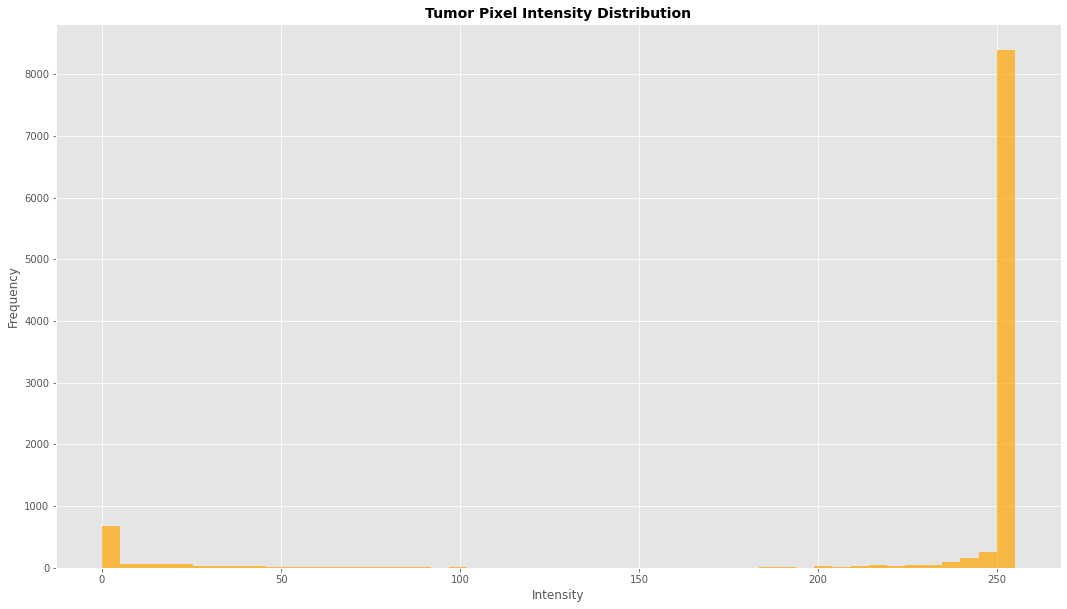

ValueError: num must be an integer with 1 <= num <= 6, not 9

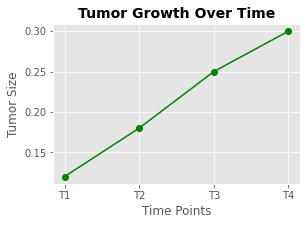

In [15]:
fig = plt.figure(figsize=(18, 10))
grid_rows = 3  # Increase rows
grid_cols = 3  # Increase columns

# Resize segmented_mask to match img_original's shape (height, width)
resized_mask = cv2.resize(segmented_mask, (img_original.shape[1], img_original.shape[0]), interpolation=cv2.INTER_NEAREST)

# Ensure the mask is binary (0 or 1)
resized_mask = resized_mask > 0

# Extract tumor pixels
tumor_pixels = img_original[resized_mask]
plt.hist(tumor_pixels.ravel(), bins=50, color='orange', alpha=0.7)
plt.title("Tumor Pixel Intensity Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

# Update the subplot grid to 3x3
plt.figure(figsize=(15, 10))
grid_rows, grid_cols = 3, 3

# Example for the 8th plot: Tumor Growth Over Time
plt.subplot(grid_rows, grid_cols, 8)
time_points = ['T1', 'T2', 'T3', 'T4']
tumor_sizes = [0.12, 0.18, 0.25, 0.30]  # Replace with real data
plt.plot(time_points, tumor_sizes, marker='o', color='green')
plt.title("Tumor Growth Over Time", fontsize=14, fontweight='bold')
plt.xlabel("Time Points")
plt.ylabel("Tumor Size")
plt.grid(True)


# 10. Texture Analysis
plt.subplot(2, 3, 9)
from skimage.feature import greycomatrix, greycoprops
gray_img = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
glcm = greycomatrix(gray_img, distances=[1], angles=[0], symmetric=True, normed=True)
contrast = greycoprops(glcm, 'contrast')[0, 0]
correlation = greycoprops(glcm, 'correlation')[0, 0]
plt.bar(['Contrast', 'Correlation'], [contrast, correlation], color='teal')
plt.title("Tumor Texture Metrics", fontsize=14, fontweight='bold')

# 11. Radial Distribution
from scipy.ndimage import distance_transform_edt
plt.subplot(2, 3, 10)
distances = distance_transform_edt(segmented_mask)
tumor_intensity_radial = tumor_pixels.ravel() / (distances[segmented_mask > 0].ravel() + 1)
plt.hist(tumor_intensity_radial, bins=50, color='magenta', alpha=0.6)
plt.title("Radial Intensity Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Intensity/Distance")
plt.ylabel("Frequency")

# 12. Convex Hull Shape Analysis
from scipy.spatial import ConvexHull
plt.subplot(2, 3, 11)
tumor_coords = np.column_stack(np.where(segmented_mask > 0))
if tumor_coords.shape[0] > 3:  # Convex Hull requires at least 4 points
    hull = ConvexHull(tumor_coords)
    for simplex in hull.simplices:
        plt.plot(tumor_coords[simplex, 1], tumor_coords[simplex, 0], 'r-')
plt.imshow(segmented_mask, cmap='gray')
plt.title("Tumor Shape: Convex Hull", fontsize=14, fontweight='bold')
plt.axis('off')

# 13. Segmentation Accuracy
ground_truth = cv2.imread('ground_truth_mask.png', 0)  # Replace with actual ground truth mask
plt.subplot(2, 3, 12)
overlap = np.logical_and(segmented_mask, ground_truth)
plt.imshow(overlap, cmap='viridis')
plt.title("Segmentation Overlap with Ground Truth", fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()